In [315]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import shapiro

from statsmodels.stats.proportion import proportions_ztest # сравнение долей
from scipy.stats import ttest_ind, mannwhitneyu # сравнение средних

In [316]:
sample_a = pd.read_csv('C:\SkillFactory\SF_DataScience\Current_tasks\data\MPV_3\sample_a.csv')
sample_b = pd.read_csv('C:\SkillFactory\SF_DataScience\Current_tasks\data\MPV_3\sample_b.csv')
sample_c = pd.read_csv('C:\SkillFactory\SF_DataScience\Current_tasks\data\MPV_3\sample_c.csv')
item_prices = pd.read_csv('C:\SkillFactory\SF_DataScience\Current_tasks\data\MPV_3\item_prices.csv')

In [317]:
sample_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [318]:
item_prices.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


In [319]:
# Очистка от дубликатов
sample_a = sample_a.drop_duplicates()
sample_b = sample_b.drop_duplicates()
sample_c = sample_c.drop_duplicates()

In [320]:
# Объединение данных
sample_a = sample_a.merge(item_prices, left_on='item_id', right_on='item_id')
sample_b = sample_b.merge(item_prices, left_on='item_id', right_on='item_id')
sample_c = sample_c.merge(item_prices, left_on='item_id', right_on='item_id')

In [321]:
# Кодирование признаков действия для sample_a
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(sample_a[['action_id']]).toarray ())
encoded_sample_a = sample_a.join(encoder_df)

encoded_sample_a.columns = ['user_id', 'item_id', 'action_id', 'item_price', 'clicks', 'views', 'purchases']
encoded_sample_a.drop(['action_id'], axis=1, inplace=True)

In [322]:
# Группировка по пользователям и товарам для sample_a
grouped_sample_a = encoded_sample_a.groupby(['user_id', 'item_id', 'item_price'], as_index=False).agg({
    'clicks':'sum',
    'views':'sum',
    'purchases':'sum'
})

grouped_sample_a['purchases_amount'] = grouped_sample_a['purchases'] * grouped_sample_a['item_price']

In [323]:
# Кодирование признаков действия для sample_b
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(sample_b[['action_id']]).toarray ())
encoded_sample_b = sample_b.join(encoder_df)

encoded_sample_b.columns = ['user_id', 'item_id', 'action_id', 'item_price', 'clicks', 'views', 'purchases']
encoded_sample_b.drop(['action_id'], axis=1, inplace=True)

In [324]:
# Группировка по пользователям и товарам для sample_b
grouped_sample_b = encoded_sample_b.groupby(['user_id', 'item_id', 'item_price'], as_index=False).agg({
    'clicks':'sum',
    'views':'sum',
    'purchases':'sum'
})

grouped_sample_b['purchases_amount'] = grouped_sample_b['purchases'] * grouped_sample_b['item_price']

In [325]:
# Кодирование признаков действия для sample_c
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(sample_c[['action_id']]).toarray ())
encoded_sample_c = sample_c.join(encoder_df)

encoded_sample_c.columns = ['user_id', 'item_id', 'action_id', 'item_price', 'clicks', 'views', 'purchases']
encoded_sample_c.drop(['action_id'], axis=1, inplace=True)

In [326]:
# Группировка по пользователям и товарам для sample_c
grouped_sample_c = encoded_sample_c.groupby(['user_id', 'item_id', 'item_price'], as_index=False).agg({
    'clicks':'sum',
    'views':'sum',
    'purchases':'sum'
})

grouped_sample_c['purchases_amount'] = grouped_sample_c['purchases'] * grouped_sample_c['item_price']

In [327]:
# Проверка на наличие покупов/кликов без просмотров
print('Проверка sample_a')
print(grouped_sample_a[(grouped_sample_a['views'] == 0) & (grouped_sample_a['clicks'] == 1)].shape[0])
print(grouped_sample_a[(grouped_sample_a['views'] == 0) & (grouped_sample_a['purchases'] == 1)].shape[0])

print('Проверка sample_b')
print(grouped_sample_b[(grouped_sample_b['views'] == 0) & (grouped_sample_b['clicks'] == 1)].shape[0])
print(grouped_sample_b[(grouped_sample_b['views'] == 0) & (grouped_sample_b['purchases'] == 1)].shape[0])

print('Проверка sample_c')
print(grouped_sample_c[(grouped_sample_c['views'] == 0) & (grouped_sample_c['clicks'] == 1)].shape[0])
print(grouped_sample_c[(grouped_sample_c['views'] == 0) & (grouped_sample_c['purchases'] == 1)].shape[0])

Проверка sample_a
0
0
Проверка sample_b
0
0
Проверка sample_c
0
0


In [328]:
# Формирование датасета по группе sample_a с целевыми метриками по сессиям (1 сессия 1 пользователь)
df_stats_a = pd.DataFrame(columns=['user_id', 'ctr', 'purchase_rate', 'gvm'])

for user_id in grouped_sample_a.user_id.unique():
    df_stats_a.loc[len(df_stats_a.index)] = [
    user_id,
    grouped_sample_a[grouped_sample_a['user_id'] == user_id].clicks.sum() / grouped_sample_a[grouped_sample_a['user_id'] == user_id].views.sum(),
    grouped_sample_a[grouped_sample_a['user_id'] == user_id].purchases.sum() / grouped_sample_a[grouped_sample_a['user_id'] == user_id].views.sum(),
    grouped_sample_a[grouped_sample_a['user_id'] == user_id].purchases_amount.sum()
]

In [329]:
# Формирование датасета по группе sample_b с целевыми метриками по сессиям (1 сессия 1 пользователь)
df_stats_b = pd.DataFrame(columns=['user_id', 'ctr', 'purchase_rate', 'gvm'])

for user_id in grouped_sample_b.user_id.unique():
    df_stats_b.loc[len(df_stats_b.index)] = [
    user_id,
    grouped_sample_b[grouped_sample_b['user_id'] == user_id].clicks.sum() / grouped_sample_b[grouped_sample_b['user_id'] == user_id].views.sum(),
    grouped_sample_b[grouped_sample_b['user_id'] == user_id].purchases.sum() / grouped_sample_b[grouped_sample_b['user_id'] == user_id].views.sum(),
    grouped_sample_b[grouped_sample_b['user_id'] == user_id].purchases_amount.sum()
]

In [330]:
# Формирование датасета по группе sample_c с целевыми метриками по сессиям (1 сессия 1 пользователь)
df_stats_c = pd.DataFrame(columns=['user_id', 'ctr', 'purchase_rate', 'gvm'])

for user_id in grouped_sample_c.user_id.unique():
    df_stats_c.loc[len(df_stats_c.index)] = [
    user_id,
    grouped_sample_c[grouped_sample_c['user_id'] == user_id].clicks.sum() / grouped_sample_c[grouped_sample_c['user_id'] == user_id].views.sum(),
    grouped_sample_c[grouped_sample_c['user_id'] == user_id].purchases.sum() / grouped_sample_c[grouped_sample_c['user_id'] == user_id].views.sum(),
    grouped_sample_c[grouped_sample_c['user_id'] == user_id].purchases_amount.sum()
]

### Выполнение статистических тестов на нормальность

In [331]:
H0 = 'Распределения нормальное'
H1 = 'Распределение отлично от нормального'

alpha = 0.01

for metric in ['ctr', 'purchase_rate', 'gvm']:
    shapiro_a = shapiro(df_stats_a[metric])

    if shapiro_a.pvalue < alpha:
        print("Результаты теста для метрики {} (sample_a)".format(metric))
        print("Отвергаем нулевую гипотезу. {}".format(H0))
        print("Принимаем альтернативную гипотезу. H1: {}".format(H1))
        print("_________________________________________________________")
    else:
        print("Результаты теста для метрики {} (sample_a)".format(metric))
        print("Принимаем нулевую гипотезу. {}".format(H0))
        print("_________________________________________________________")

Результаты теста для метрики ctr (sample_a)
Отвергаем нулевую гипотезу. Распределения нормальное
Принимаем альтернативную гипотезу. H1: Распределение отлично от нормального
_________________________________________________________
Результаты теста для метрики purchase_rate (sample_a)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________
Результаты теста для метрики gvm (sample_a)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________


In [332]:
H0 = 'Распределения нормальное'
H1 = 'Распределение отлично от нормального'

alpha = 0.01

for metric in ['ctr', 'purchase_rate', 'gvm']:
    shapiro_a = shapiro(df_stats_b[metric])

    if shapiro_a.pvalue < alpha:
        print("Результаты теста для метрики {} (sample_b)".format(metric))
        print("Отвергаем нулевую гипотезу. {}".format(H0))
        print("Принимаем альтернативную гипотезу. H1: {}".format(H1))
        print("_________________________________________________________")
    else:
        print("Результаты теста для метрики {} (sample_b)".format(metric))
        print("Принимаем нулевую гипотезу. {}".format(H0))
        print("_________________________________________________________")

Результаты теста для метрики ctr (sample_b)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________
Результаты теста для метрики purchase_rate (sample_b)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________
Результаты теста для метрики gvm (sample_b)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________


In [333]:
H0 = 'Распределения нормальное'
H1 = 'Распределение отлично от нормального'

alpha = 0.01

for metric in ['ctr', 'purchase_rate', 'gvm']:
    shapiro_a = shapiro(df_stats_c[metric])

    if shapiro_a.pvalue < alpha:
        print("Результаты теста для метрики {} (sample_c)".format(metric))
        print("Отвергаем нулевую гипотезу. {}".format(H0))
        print("Принимаем альтернативную гипотезу. H1: {}".format(H1))
        print("_________________________________________________________")
    else:
        print("Результаты теста для метрики {} (sample_c)".format(metric))
        print("Принимаем нулевую гипотезу. {}".format(H0))
        print("_________________________________________________________")

Результаты теста для метрики ctr (sample_c)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________
Результаты теста для метрики purchase_rate (sample_c)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________
Результаты теста для метрики gvm (sample_c)
Принимаем нулевую гипотезу. Распределения нормальное
_________________________________________________________


### Общий анализ полученных метрик по сэмплам

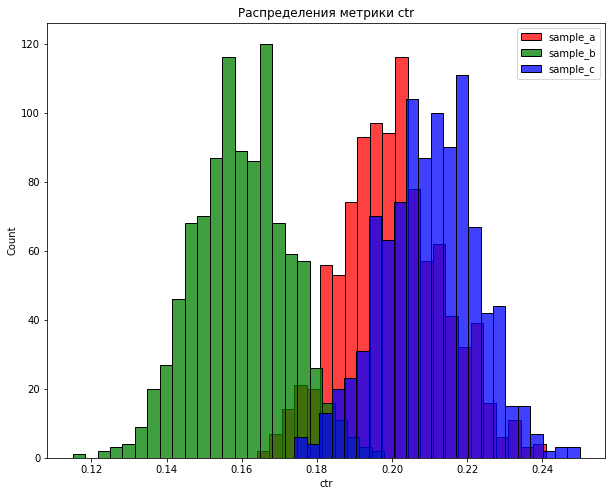

In [334]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения метрики ctr')

sns.histplot(df_stats_a['ctr'], ax=ax1, color='red')
sns.histplot(df_stats_b['ctr'], ax=ax1, color='green')
sns.histplot(df_stats_c['ctr'], ax=ax1, color='blue')
ax1.legend(['sample_a', 'sample_b', 'sample_c']);

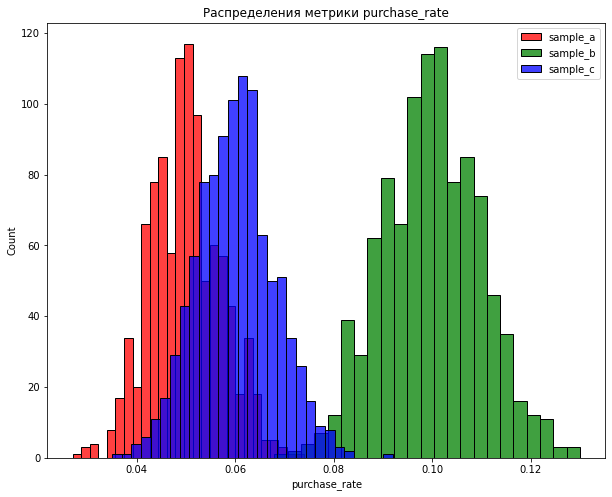

In [335]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения метрики purchase_rate')

sns.histplot(df_stats_a['purchase_rate'], ax=ax1, color='red')
sns.histplot(df_stats_b['purchase_rate'], ax=ax1, color='green')
sns.histplot(df_stats_c['purchase_rate'], ax=ax1, color='blue')
ax1.legend(['sample_a', 'sample_b', 'sample_c']);

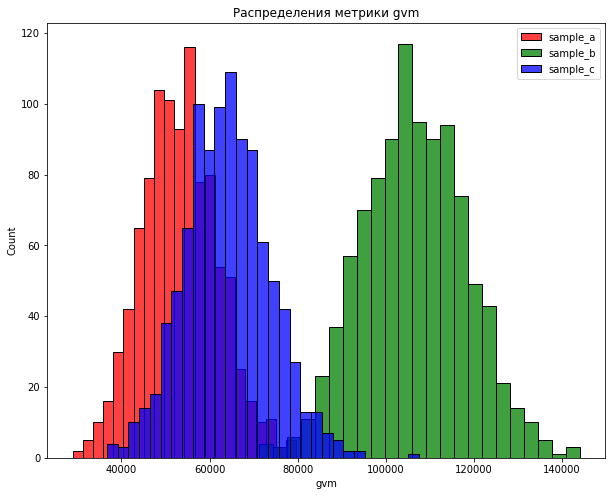

In [336]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения метрики gvm')

sns.histplot(df_stats_a['gvm'], ax=ax1, color='red')
sns.histplot(df_stats_b['gvm'], ax=ax1, color='green')
sns.histplot(df_stats_c['gvm'], ax=ax1, color='blue')
ax1.legend(['sample_a', 'sample_b', 'sample_c']);

### Выполнение статистических тестов для сэмплов A и C

In [337]:
# Метрика ctr для sample_a распределена отлично от нормального, поэтому необходимо использовать
# U-критерий Манна-Уитни
H0 = 'Среднее значение метрики ctr одинаково'
H1 = 'Среднее значение метрики ctr в группе А меньше, чем в группе С'

alpha = 0.01 

result = mannwhitneyu(
    x=df_stats_a['ctr'],
    y=df_stats_c['ctr'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу Среднее значение метрики ctr одинаково
Альтернативная гипотеза H1: Среднее значение метрики ctr в группе А меньше, чем в группе С


In [338]:
# Метрика purchase_rate имеет нормальное распределение в обоих сэмплах, поэтому необходимо использовать
# Двухвыборочный t-критерий
H0 = 'Среднее значение метрики purchase_rate одинаково'
H1 = 'Среднее значение метрики purchase_rate в группе А меньше, чем в группе С'

alpha = 0.01 

result = ttest_ind(
    a=df_stats_a['purchase_rate'],
    b=df_stats_c['purchase_rate'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу Среднее значение метрики purchase_rate одинаково
Альтернативная гипотеза H1: Среднее значение метрики purchase_rate в группе А меньше, чем в группе С


In [339]:
# Метрика gvm имеет нормальное распределение в обоих сэмплах, поэтому необходимо использовать
# Двухвыборочный t-критерий
H0 = 'Среднее значение метрики gvm одинаково'
H1 = 'Среднее значение метрики gvm в группе А меньше, чем в группе С'

alpha = 0.01 

result = ttest_ind(
    a=df_stats_a['gvm'],
    b=df_stats_c['gvm'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу Среднее значение метрики gvm одинаково
Альтернативная гипотеза H1: Среднее значение метрики gvm в группе А меньше, чем в группе С


По результатам выполненных статистических тестов можно сделать вывод, что по всем метрикам sample_c превосходит sample_a с заданным уровнем статистической значимости.

### Выполнение статистических тестов для сэмплов A и B

In [340]:
# Метрика ctr для sample_a распределена отлично от нормального, поэтому необходимо использовать
# U-критерий Манна-Уитни
H0 = 'Среднее значение метрики ctr одинаково'
H1 = 'Среднее значение метрики ctr в группе А меньше, чем в группе B'

alpha = 0.01 

result = mannwhitneyu(
    x=df_stats_a['ctr'],
    y=df_stats_b['ctr'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Принимаем нулевую гипотезу. Среднее значение метрики ctr одинаково


In [341]:
# Метрика purchase_rate имеет нормальное распределение в обоих сэмплах, поэтому необходимо использовать
# Двухвыборочный t-критерий
H0 = 'Среднее значение метрики purchase_rate одинаково'
H1 = 'Среднее значение метрики purchase_rate в группе А меньше, чем в группе B'

alpha = 0.01 

result = ttest_ind(
    a=df_stats_a['purchase_rate'],
    b=df_stats_b['purchase_rate'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу Среднее значение метрики purchase_rate одинаково
Альтернативная гипотеза H1: Среднее значение метрики purchase_rate в группе А меньше, чем в группе B


In [342]:
# Метрика gvm имеет нормальное распределение в обоих сэмплах, поэтому необходимо использовать
# Двухвыборочный t-критерий
H0 = 'Среднее значение метрики gvm одинаково'
H1 = 'Среднее значение метрики gvm в группе А меньше, чем в группе B'

alpha = 0.01 

result = ttest_ind(
    a=df_stats_a['gvm'],
    b=df_stats_b['gvm'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу Среднее значение метрики gvm одинаково
Альтернативная гипотеза H1: Среднее значение метрики gvm в группе А меньше, чем в группе B


По результатам А/А теста можно сделать вывод, что по метрикам purchase_rate и gvm сплиты разъезжаются.